<a href="https://colab.research.google.com/github/Chimamuelo/Simple-Cnn-Pytorch/blob/main/MultiLabel_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *

In [2]:
#Download data
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.csv')]

In [3]:
df = pd.read_csv(path/'train.csv')
df[:10]

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
5,000017.jpg,person horse,False
6,000019.jpg,cat,True
7,000020.jpg,car,True
8,000021.jpg,dog person,True
9,000023.jpg,bicycle person,False


In [4]:
df_test= pd.read_csv(path/'test.csv')

In [5]:
df_test.head()

,fname,labels
0,000001.jpg,dog person
1,000002.jpg,train
2,000003.jpg,sofa chair
3,000004.jpg,car
4,000006.jpg,pottedplant diningtable chair


In [6]:
df.labels=df.labels.str.split()
df_test.labels=df_test.labels.str.split()

In [7]:
df[:10]

,fname,labels,is_valid
0,000005.jpg,[chair],True
1,000007.jpg,[car],True
2,000009.jpg,"[horse, person]",True
3,000012.jpg,[car],False
4,000016.jpg,[bicycle],True
5,000017.jpg,"[person, horse]",False
6,000019.jpg,[cat],True
7,000020.jpg,[car],True
8,000021.jpg,"[dog, person]",True
9,000023.jpg,"[bicycle, person]",False


In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
lb=MultiLabelBinarizer()
labels=lb.fit_transform(df.labels)
valid_labels=lb.fit_transform(df_test.labels)

In [9]:
labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
lb.inverse_transform(labels)[2]

('horse', 'person')

In [11]:
path

Path('/root/.fastai/data/pascal_2007')

In [12]:
folder_dir = '/root/.fastai/data/pascal_2007/train'
valid_dir='/root/.fastai/data/pascal_2007/test'
print(len(os.listdir(folder_dir)))

5012


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from torchvision.io import read_image

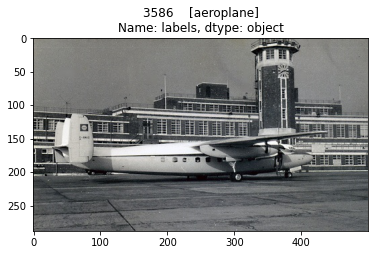

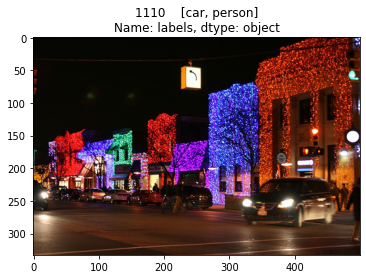

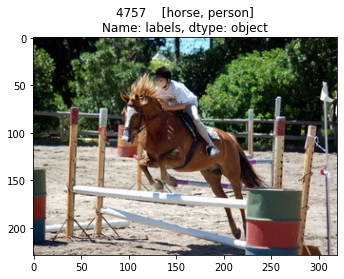

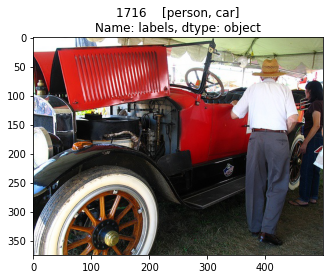

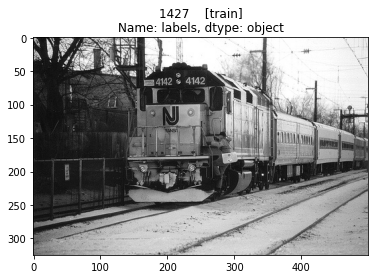

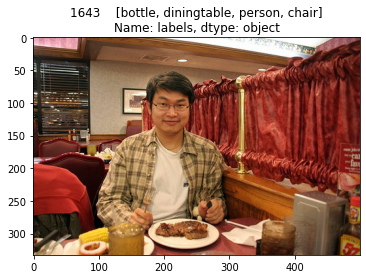

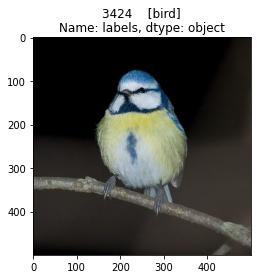

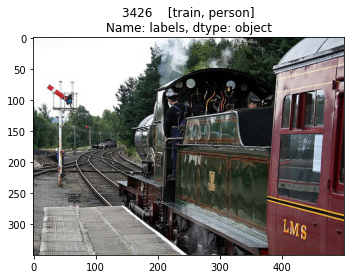

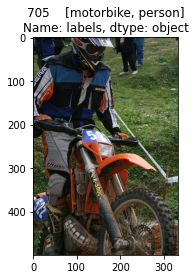

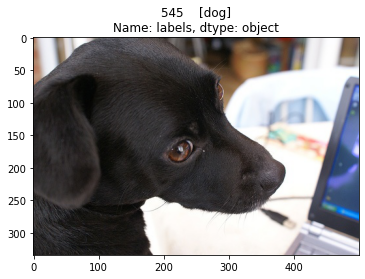

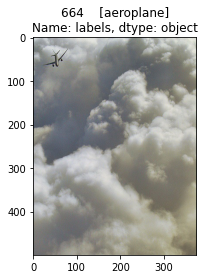

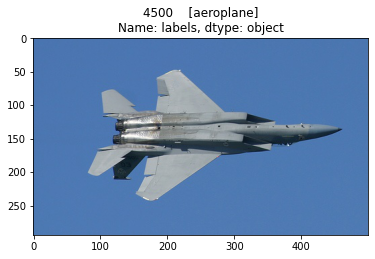

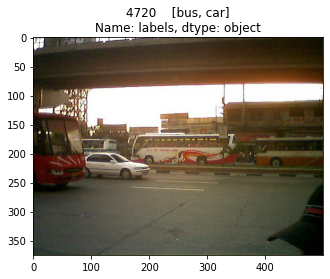

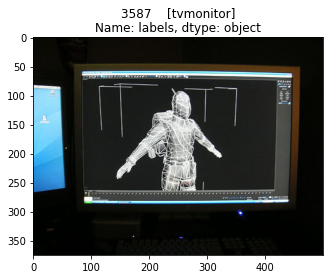

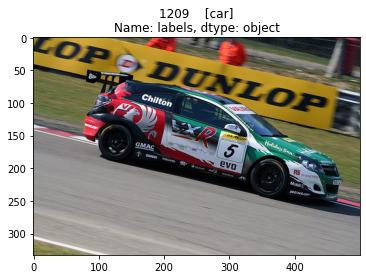

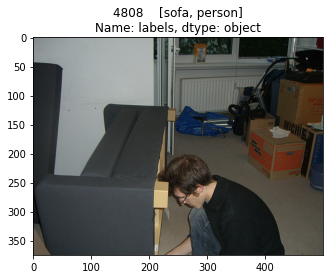

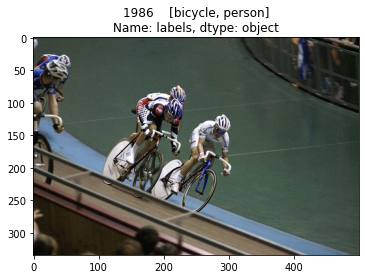

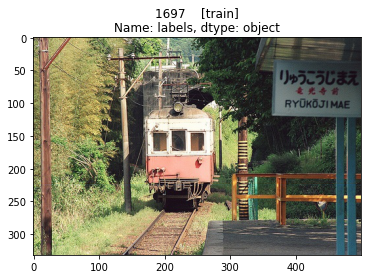

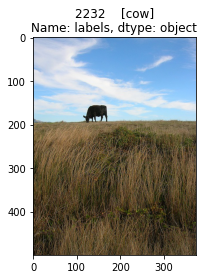

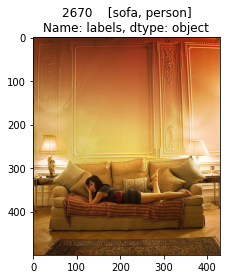

In [14]:
for i in range(20):
  x=os.listdir(folder_dir)[i]
  label=df.labels.loc[df.fname==x]
  
  path_upt=folder_dir+str('/')+x
  img=mpimg.imread(path_upt)
  
  plt.imshow(img)
  plt.title(str(label))
  plt.show()

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [16]:
transform=transforms.Compose([
                              transforms.Resize([96,96]),
                             transforms.ToTensor(),

                              ]
                             )

In [17]:
from skimage import io

In [18]:
labels[6]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
df.fname.iloc[5000]

'009944.jpg'

In [20]:
class MultiDataset(Dataset):
  def __init__(self,folder_dir,y,transform,df):
    self.folder=folder_dir
    self.label=y
    self.transform=transform
    self.df=df
  def __len__(self):
    return len(self.label)
  
  def __getitem__(self, idx):
    image_path=os.path.join(self.folder,self.df.fname.iloc[idx])
    
    image=Image.open(image_path)
    img=self.transform(image)
    
    return img,self.label[idx]

In [21]:
dataset=MultiDataset(folder_dir,labels,transform,df)
valid_dataset=MultiDataset(valid_dir,valid_labels,transform,df_test)

In [22]:
dataset[1][0].shape

torch.Size([3, 96, 96])

In [23]:
valid_dataset[1][0].shape

torch.Size([3, 96, 96])

In [24]:
dataloader=DataLoader(dataset,shuffle=True,batch_size=2)
valid_loader=DataLoader(valid_dataset,batch_size=2)

In [25]:
class MultiModel(nn.Module):
  def __init__(self,in_channels,out_channels,n_classes=20):
    super().__init__()

    self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1)
    self.drop=nn.Dropout(.2)
    self.pool=nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(out_channels,36,kernel_size=3,stride=1)
    
    self.linear=nn.Linear(17424,2048)
    self.linear2=nn.Linear(2048,256)
    self.out=nn.Linear(256,n_classes)
    
    self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    x =self.pool(F.relu(self.conv1(x)))
   # print(x.shape)
    x=self.drop(x)
    x =self.pool(F.relu(self.conv2(x)))
    #print(x.shape)
    
    x=self.drop(x)

    x = x.view(x.size(0), -1)# flatten all dimensions except batch
    #print(x.shape)
    x = F.relu(self.linear(x))
    x = F.relu(self.linear2(x))
   
    
    x = self.out(x)
    x=self.sigmoid(x)
    return x


In [26]:
model=MultiModel(3,24)
device = torch.device("cuda")
model.to(device)

MultiModel(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1))
  (drop): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1))
  (linear): Linear(in_features=17424, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=20, bias=True)
  (sigmoid): Sigmoid()
)

In [27]:
!pip install torchmetrics attrdict -q

In [28]:
import torch.optim as optim
import torchmetrics

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
metric = torchmetrics.Accuracy()
metric=metric.to(device)

In [29]:
for i, data in enumerate(dataloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    
    print(inputs[0])
    print(labels)
    
    break

tensor([[[0.4235, 0.4275, 0.4314,  ..., 0.5059, 0.4745, 0.4549],
         [0.4275, 0.4353, 0.4392,  ..., 0.5176, 0.4824, 0.4667],
         [0.4275, 0.4353, 0.4392,  ..., 0.5294, 0.5137, 0.5294],
         ...,
         [0.3176, 0.3294, 0.3333,  ..., 0.0118, 0.0118, 0.0157],
         [0.3137, 0.3216, 0.3255,  ..., 0.0118, 0.0118, 0.0118],
         [0.3098, 0.3176, 0.3255,  ..., 0.0157, 0.0118, 0.0118]],

        [[0.3686, 0.3725, 0.3765,  ..., 0.3725, 0.3529, 0.3412],
         [0.3725, 0.3804, 0.3843,  ..., 0.3804, 0.3569, 0.3490],
         [0.3725, 0.3804, 0.3843,  ..., 0.3882, 0.3843, 0.4118],
         ...,
         [0.2784, 0.2824, 0.2902,  ..., 0.0196, 0.0196, 0.0196],
         [0.2706, 0.2784, 0.2863,  ..., 0.0196, 0.0196, 0.0196],
         [0.2667, 0.2706, 0.2824,  ..., 0.0196, 0.0157, 0.0196]],

        [[0.3608, 0.3686, 0.3725,  ..., 0.3529, 0.3451, 0.3333],
         [0.3686, 0.3804, 0.3804,  ..., 0.3569, 0.3490, 0.3490],
         [0.3686, 0.3765, 0.3804,  ..., 0.3686, 0.3765, 0.

In [30]:
train_losses_step = []
train_losses = []
valid_losses = []

for epoch in range(10):
  running_loss = 0.0
  model.train()
  for i, data in enumerate(dataloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs=inputs.to(device)
    labels=labels.to(device)
    

      # zero the parameter gradients
    optimizer.zero_grad()

      # forward + backward + optimize
    outputs = model(inputs)
   
    
    loss = criterion(outputs, labels.type(torch.float))
   
    loss.backward()
    optimizer.step()

    batch_acc = metric(outputs,labels.int())
    running_loss += loss
    train_losses_step.append(loss.item())
   
  running_loss /= len(dataloader)
  train_losses.append(running_loss.item())
  train_acc = metric.compute()
 
  
  model.eval() 
  val_loss=0
  for i, data in enumerate(valid_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs=inputs.to(device)
    
    labels=labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels.type(torch.float))
    batch_acc = metric(outputs,labels.int())
    val_loss += loss


  val_loss /= len(valid_loader)
  valid_losses.append(val_loss.item())
  valid_acc = metric.compute()
  
  
  print(f"Epoch: {epoch}, Train loss: {running_loss:.04f} Train acc: {float(train_acc):.04f}, Valid loss: {val_loss} Valid Acc: {float(valid_acc):.04f}")
     

Epoch: 0, Train loss: 0.2538 Train acc: 0.9201, Valid loss: 0.24245740473270416 Valid Acc: 0.9215
Epoch: 1, Train loss: 0.2486 Train acc: 0.9213, Valid loss: 0.24232202768325806 Valid Acc: 0.9217
Epoch: 2, Train loss: 0.2480 Train acc: 0.9215, Valid loss: 0.24348430335521698 Valid Acc: 0.9218
Epoch: 3, Train loss: 0.2479 Train acc: 0.9217, Valid loss: 0.24065452814102173 Valid Acc: 0.9218
Epoch: 4, Train loss: 0.2567 Train acc: 0.9217, Valid loss: 0.24047473073005676 Valid Acc: 0.9218
Epoch: 5, Train loss: 0.2475 Train acc: 0.9218, Valid loss: 0.24034366011619568 Valid Acc: 0.9219
Epoch: 6, Train loss: 0.2473 Train acc: 0.9218, Valid loss: 0.24036096036434174 Valid Acc: 0.9219
Epoch: 7, Train loss: 0.2471 Train acc: 0.9218, Valid loss: 0.240193709731102 Valid Acc: 0.9219
Epoch: 8, Train loss: 0.2471 Train acc: 0.9218, Valid loss: 0.24061614274978638 Valid Acc: 0.9219
Epoch: 9, Train loss: 0.2470 Train acc: 0.9219, Valid loss: 0.24055080115795135 Valid Acc: 0.9219


In [42]:
image=Image.open("/content/golden.jpg")

In [43]:
x=transform(image)

In [44]:
x=torch.tensor(x,dtype=torch.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [45]:
x=x.unsqueeze(0)
x=x.to(device)

In [46]:
x.shape

torch.Size([1, 3, 96, 96])

In [47]:
pred=model(x)

In [48]:
pred

tensor([[0.0415, 0.0426, 0.0698, 0.0280, 0.0521, 0.0380, 0.1493, 0.0523, 0.0943,
         0.0326, 0.0441, 0.0630, 0.0649, 0.0447, 0.4349, 0.0406, 0.0171, 0.0681,
         0.0412, 0.0452]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [38]:
pred=sigmoid(pred)

In [51]:
pred.round()

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0', grad_fn=<RoundBackward0>)

In [52]:
f=lb.inverse_transform(pred.detach().cpu().round())

In [53]:
f

[()]